### Video Processing and data extraction

In [2165]:
from ultralytics import YOLO
import pandas as pd

# Load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Run inference on the video
results = model(source="entropy (online-video-cutter.com).mp4", stream=True, show=True, conf=0.4, save=True)

# Prepare a list to store the tracking data
# Process the results

data = []  # Initialize an empty list to store the data
for frame_num, result in enumerate(results):
    boxes = result.boxes.xywh  # Get bounding boxes in xywh format (x, y, width, height)
    for obj_id, box in enumerate(boxes):  # Fix: Unpack values from boxes using enumerate()
        x, y, w, h = box[:4].tolist()
        # Calculate the center position of the box
        center_x = x + w / 2
        center_y = y + h / 2
        data.append([frame_num, obj_id, center_x, center_y])

df = pd.DataFrame(data, columns=['frame', 'id', 'center_x', 'center_y'])

# Sort the DataFrame by 'id' and 'frame'
df = df.sort_values(by= ['id','frame'])

# Calculate velocities
df[['vx', 'vy']] = df.groupby('id')[['center_x', 'center_y']].diff().fillna(0)

# Saved the DataFrame to a CSV file
df.to_csv('positions.csv', index=False)

print("Tracking data with velocities saved to 'positions.csv'.")


video 1/1 (frame 1/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 2 persons, 199.6ms
video 1/1 (frame 2/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 2 persons, 191.0ms
video 1/1 (frame 3/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 2 persons, 137.9ms
video 1/1 (frame 4/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 2 persons, 95.5ms
video 1/1 (frame 5/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 2 persons, 111.1ms
video 1/1 (frame 6/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 2 persons, 102.5ms
video 1/1 (frame 7/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 2 persons, 1 bird, 100.6ms
video 1/1 (frame 8/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 1 person, 1 bird, 74.2ms
video 1/1 (frame 9/260) /Users/abhijitdalai/entropy (online-video-cutter.com).mp4: 480x640 1 person, 1 bir

### Ensemble Kalman smoothing

In [ ]:
import numpy as np
import pandas as pd

def EnKS(Z, f, h, M, m, max_iter=10):
    """
    Estimates crowd state distributions using EnKS.

    Args:
        Z: Measured crowd data, a list of nd-dimensional vectors.
        f: Transition function.
        h: Observation function.
        M: Estimated error variance, a d x d covariance matrix.
        m: Number of ensemble members.
        max_iter: Maximum number of iterations for convergence.

    Returns:
        X: Estimated crowd state distributions, a list of lists of nd-dimensional vectors,
           each sublist representing a distribution of crowd states at a specific timestep.
    """
    n = len(Z[0])  # Measurement dimension
    d = n * 2      # State dimension (position + velocity)
    X = [np.random.randn(m, d) for _ in range(len(Z))]  # Initialize state with position and velocity

    for iteration in range(max_iter):
        # Forward pass
        for k in range(1, len(Z)):
            X_pred = [f(x) for x in X[k-1]]
            Z_pred = [h(x) for x in X_pred]

            Z_pred_mean = np.mean(Z_pred, axis=0)
            P_zz = np.cov(np.array(Z_pred).T) + np.eye(n) * 1e-5
            P_xz = np.cov(np.array(X_pred).T, np.array(Z_pred).T)[:d, d:]

            try:
                K = P_xz @ np.linalg.inv(P_zz + M + np.eye(n) * 1e-5)  # Regularize to ensure invertibility
            except np.linalg.LinAlgError:
                K = P_xz @ np.linalg.pinv(P_zz + M + np.eye(n) * 1e-5)  # Use pseudo-inverse if singular

            for i in range(m):
                innovation = Z[k] - Z_pred_mean
                X[k][i] = X_pred[i] + K @ innovation

        # Backward pass
        for k in range(len(Z) - 2, -1, -1):
            P_xx = np.cov(np.array(X[k]).T) + np.eye(d) * 1e-5  # Regularize to ensure positive definiteness
            try:
                G = P_xx @ np.linalg.inv(P_xx + np.eye(d) * 1e-5)  # Only use P_xx for G calculation
            except np.linalg.LinAlgError:
                G = P_xx @ np.linalg.pinv(P_xx + np.eye(d) * 1e-5)  # Use pseudo-inverse if singular
            for i in range(m):
                X[k][i] = X[k][i] + G @ (X[k+1][i] - f(X[k][i]))

    return X

def transition_func(state, process_noise=0.1):
    """
    Transition function for the state evolution.
    
    Args:
        state (np.array): Current state vector, including position and velocity.
        process_noise (float): Standard deviation of the process noise.
    
    Returns:
        np.array: New state vector after transition.
    """
    position = state[:2]
    velocity = state[2:]
    
    # Update position based on velocity
    new_position = position + velocity

    # Add process noise
    noise = np.random.normal(0, process_noise, size=state.shape)
    new_state = np.concatenate((new_position, velocity)) + noise
    
    return new_state

def observation_func(state):
    """
    Observation function for mapping the state to the observed measurements.
    
    Args:
        state (np.array): State vector, including position and velocity.
    
    Returns:
        np.array: Observed measurement vector (position only).
    """
    position = state[:2]
    return position

# Load the positions file
positions_df = pd.read_csv('positions.csv')
measurements = positions_df[['center_x', 'center_y']].values

# Initialize parameters
num_ensembles = 100
state_dim = 2  # Assuming 2D positions
process_noise = np.eye(state_dim * 2) * 0.05  # For position and velocity
measurement_noise = np.eye(state_dim) * 0.05

# Perform Ensemble Kalman Smoothing
estimated_states = EnKS(measurements, transition_func, observation_func, measurement_noise, num_ensembles)

# Convert the states list to a numpy array for further processing
estimated_states = np.array(estimated_states)

# Save the estimated states to a file for further use
np.save('estimated_states.npy', estimated_states)

print("State estimation complete. Estimated states saved to 'estimated_states.npy'.")


State estimation complete. Estimated states saved to 'estimated_states.npy'.


In [2166]:
loaded_states = np.load('estimated_states.npy')

In [ ]:
reshaped_states = loaded_states.reshape(-1, 4)

estimated_states_df = pd.DataFrame(reshaped_states, columns=['estimated_center_x', 'estimated_center_y', 'estimated_velocity_x', 'estimated_velocity_y'])
estimated_states_df.to_csv('estimated_states.csv', index=False)

print("Estimated states saved to 'estimated_states.csv'.")

print(estimated_states_df.head())
print(estimated_states_df.tail())

Estimated states saved to 'estimated_states.csv'.
   estimated_center_x  estimated_center_y  estimated_velocity_x  \
0       -3.863392e+07       -7.007704e+07          22137.801232   
1       -3.863389e+07       -7.007704e+07          22137.003111   
2       -3.863390e+07       -7.007704e+07          22149.839050   
3       -3.863391e+07       -7.007705e+07          22128.480407   
4       -3.863390e+07       -7.007704e+07          22133.682663   

   estimated_velocity_y  
0          37252.873418  
1          37250.676167  
2          37249.525288  
3          37252.208167  
4          37246.312994  
       estimated_center_x  estimated_center_y  estimated_velocity_x  \
30395        -2031.377091          -57.115663          23359.882979   
30396         1220.882818        -2295.364055          23372.913575   
30397        -2721.339798        -3208.332302          23357.591713   
30398         -482.130530         3081.287215          23363.805632   
30399          892.662410          2

In [2167]:
import matplotlib.pyplot as plt

In [2168]:
from scipy.stats import norm

### Steering Model

In [ ]:
class SteeringSimulation:
    def __init__(self, num_agents, state_dim, goal):
        self.num_agents = num_agents
        self.state_dim = state_dim
        self.goal = goal
        self.states = np.random.rand(num_agents, state_dim) * 100  # Scale initial positions for better visualization
        self.velocities = np.zeros((self.num_agents, self.state_dim))
        self.max_speed = 1.5
        self.neighbor_radius = 40.0
        self.obstacle_radius = 10.0
        self.density_radius = 20.0
        self.weights = {
            'seek': 1.5,
            'flee': 0.8,
            'arrive': 0.9,
            'pursuit': 0.9,
            'evade': 0.9,
            'wander': 0.8,
            'obstacle_avoidance': 1.2,
            'path_following': 1.2,
            'flocking': 1.3,
            'density': 1.0,
        }

    def calculate_density(self, agent_index):
        position = self.states[agent_index]
        neighbors = [i for i in range(self.num_agents) if np.linalg.norm(self.states[i] - position) < self.density_radius]
        density = len(neighbors) / (np.pi * self.density_radius**2)
        return density

    def seek(self, agent_position, target_position):
        desired_velocity = target_position - agent_position
        return desired_velocity / np.linalg.norm(desired_velocity)

    def flee(self, agent_position, threat_position):
        desired_velocity = agent_position - threat_position
        return desired_velocity / np.linalg.norm(desired_velocity)

    def arrive(self, agent_position, target_position, slowing_distance=10.0):
        desired_velocity = target_position - agent_position
        distance = np.linalg.norm(desired_velocity)
        if distance < slowing_distance:
            return desired_velocity * (distance / slowing_distance)
        else:
            return desired_velocity / np.linalg.norm(desired_velocity)

    def pursuit(self, agent_position, target_position, target_velocity):
        future_position = target_position + target_velocity
        return self.seek(agent_position, future_position)

    def evade(self, agent_position, threat_position, threat_velocity):
        future_position = threat_position + threat_velocity
        return self.flee(agent_position, future_position)

    def wander(self):
        angle = np.random.uniform(0, 2 * np.pi, self.num_agents)
        return np.column_stack((np.cos(angle), np.sin(angle)))

    def obstacle_avoidance(self, agent_position, obstacles):
        force = np.zeros(2)
        for obstacle in obstacles:
            direction = agent_position - obstacle
            distance = np.linalg.norm(direction)
            if distance < self.obstacle_radius:
                force += direction / distance**2
        return force

    def path_following(self, agent_position, path_points):
        # Simple path following: go to the next point in the path
        closest_point = min(path_points, key=lambda point: np.linalg.norm(agent_position - point))
        return self.seek(agent_position, closest_point)

    def flocking(self, agent_index, neighbors):
       if len(neighbors) == 0:
            return np.zeros(2)
       # Alignment
       avg_velocity = np.mean([self.velocities[i] for i in neighbors], axis=0)
       velocity_diff = avg_velocity - self.velocities[agent_index]
       alignment = velocity_diff / (np.linalg.norm(velocity_diff) + 1e-5)  
       # Cohesion
       avg_position = np.mean([self.states[i] for i in neighbors], axis=0)
       cohesion = self.seek(self.states[agent_index], avg_position)
       # Separation
       separation = np.zeros(2)
       for neighbor in neighbors:
          separation += self.flee(self.states[agent_index], self.states[neighbor])
        
       separation /= len(neighbors)
       return alignment + cohesion + separation

    def simulate(self, timesteps, obstacles, path_points):
        state_history = [self.states.copy()]
        for t in range(timesteps):
            new_velocities = np.zeros((self.num_agents, self.state_dim))
            for i in range(self.num_agents):
                current_position = self.states[i]

                # Gather all behaviors
                seek_velocity = self.seek(current_position, self.goal)
                wander_velocity = self.wander()[i]
                obstacle_avoidance_velocity = self.obstacle_avoidance(current_position, obstacles)
                path_following_velocity = self.path_following(current_position, path_points)
                
                # Flocking behavior (considering neighbors within a certain radius)
                neighbors = [j for j in range(self.num_agents) if np.linalg.norm(self.states[i] - self.states[j]) < self.neighbor_radius and i != j]
                flocking_velocity = self.flocking(i, neighbors)

                # Density effect
                density = self.calculate_density(i)
                density_effect = -density * np.ones(2)  # Simple density effect pushing agents away from dense areas

                # Combine behaviors with weights
                combined_velocity = (self.weights['seek'] * seek_velocity +
                                     self.weights['wander'] * wander_velocity +
                                     self.weights['obstacle_avoidance'] * obstacle_avoidance_velocity +
                                     self.weights['path_following'] * path_following_velocity +
                                     self.weights['flocking'] * flocking_velocity +
                                     self.weights['density'] * density_effect)

                # Normalize and apply max speed
                if np.linalg.norm(combined_velocity) > self.max_speed:
                    combined_velocity = combined_velocity / np.linalg.norm(combined_velocity) * self.max_speed

                new_velocities[i] = combined_velocity

            self.velocities = new_velocities
            self.states += self.velocities  # Update positions
            state_history.append(self.states.copy())

        return state_history

# Function to compute entropy using MLE
def compute_entropy_mle(errors):
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    entropy = np.log(2 * np.pi * np.e * error_std**2) / 2
    return entropy, error_mean, error_std

# Load the real-world positions file
real_positions_df = pd.read_csv('positions.csv')

# Load the estimated states file
estimated_states_df = pd.read_csv('estimated_states.csv')

# Extract position and velocity data from estimated states
estimated_positions = estimated_states_df[['estimated_center_x', 'estimated_center_y']].values
estimated_velocities = estimated_states_df[['estimated_velocity_x', 'estimated_velocity_y']].values

# Determine the number of frames from the real-world data
timesteps = frame_num+1#len(real_positions_df['frame'].unique())

# Run the steering simulation
num_agents = 2#estimated_positions.shape[0] // timesteps
state_dim = 2
goal = np.array([7000.0, 7.0])  # Example goal position
obstacles = [np.array([500000, 2]), np.array([500000, 2])]  # Example obstacles
path_points = [np.array([1000000, 4]), np.array([1000000, 4]), np.array([1000000, 4])]  # Example path points

steering_sim = SteeringSimulation(num_agents, state_dim, goal)
steering_states = steering_sim.simulate(timesteps, obstacles, path_points)

# Align real-world data and simulated data by frame numbers
real_positions_subset = real_positions_df[real_positions_df['frame'] < timesteps]
aligned_real_positions = real_positions_subset[['center_x', 'center_y']].values

# Since we have multiple agents, we need to match each agent's position at each frame
# Flatten the list of states and select the corresponding positions
aligned_simulated_positions = np.vstack([state for frame in steering_states[:timesteps] for state in frame[:num_agents]])

# Ensure we compare the same number of positions
# Truncate the aligned_simulated_positions array to match the length of the aligned_real_positions array
aligned_simulated_positions = aligned_simulated_positions[:len(aligned_real_positions)]

# Calculate the prediction error for each frame
prediction_errors = np.sqrt(
    (aligned_real_positions[:, 0] - aligned_simulated_positions[:, 0])**2 +
    (aligned_real_positions[:, 1] - aligned_simulated_positions[:, 1])**2
)

# Compute the entropy of the prediction error distribution using MLE
entropy_metric_steering, error_mean, error_std = compute_entropy_mle(prediction_errors)

print(f"Steering Simulation Entropy: {entropy_metric_steering}")
print(f"Error Mean: {error_mean}, Error Std: {error_std}")

# Save the final simulated states to a CSV file for further comparison
import pandas as pd

# Assuming steering_states is a list of arrays with shape (num_agents, 2)
all_frames = []

for i in range(frame_num+2):
    frame_data = pd.DataFrame(steering_states[i], columns=['sim_center_x', 'sim_center_y'])
    frame_data['frame'] = i  # Add a column to indicate the frame number
    all_frames.append(frame_data)

# Concatenate all frames into a single DataFrame
all_frames_df = pd.concat(all_frames, ignore_index=True)

# Save the concatenated DataFrame to a single CSV file
all_frames_df.to_csv('modify_states.csv', index=False)

# Load the CSV file into a DataFrame
csv_file = 'modify_states.csv'
df_s = pd.read_csv(csv_file)

# Select alternate rows (every second row starting from index 1)
alternate_rows_df = df_s.iloc[::2].reset_index(drop=True)

# Save the alternate rows to a new CSV file
alternate_rows_df.to_csv('steering_simulated_states.csv', index=False)

print("Steering simulation complete. Simulated states saved to 'steering_simulated_states.csv'.")


Steering Simulation Entropy: 4.46416857425697
Error Mean: 154.5152360334893, Error Std: 21.01486492852257
Steering simulation complete. Simulated states saved to 'steering_simulated_states.csv'.


### Agent 0 trajectory

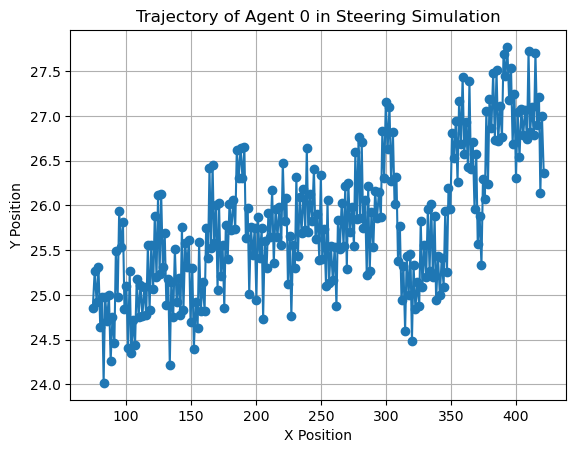

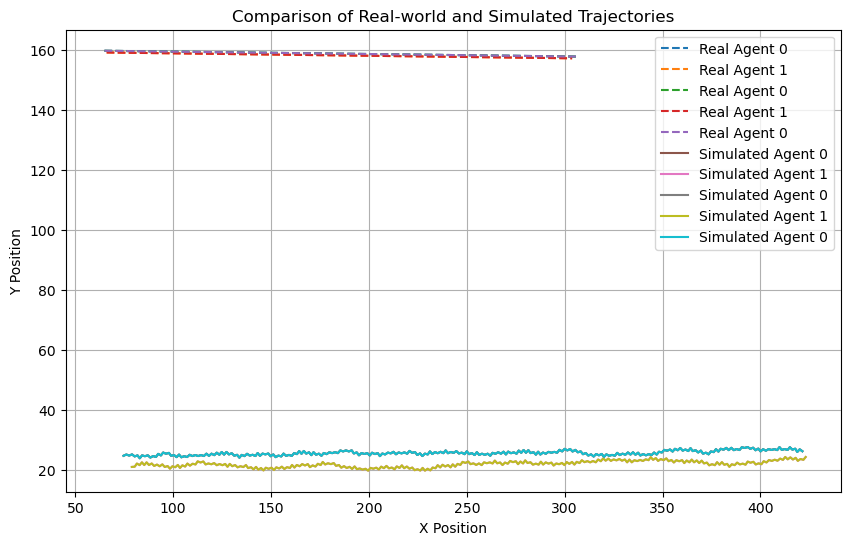

In [2169]:

# Plot of the trajectory of agent 0
agent_idx = 0
trajectory = np.array([state[agent_idx] for state in steering_states])
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.title('Trajectory of Agent 0 in Steering Simulation')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.show()

# Plotting comparison of real-world data and simulated data
# Selected a few agents for visualization
num_agents_to_plot = 5
selected_agents = np.random.choice(num_agents, num_agents_to_plot, replace=True)

# Plot trajectories
plt.figure(figsize=(10, 6))

# Plot real-world data
for agent_idx in selected_agents:
    real_trajectory = real_positions_df[real_positions_df['frame'] == agent_idx][['center_x', 'center_y']].values
    plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], label=f'Real Agent {agent_idx}', linestyle='--')

# Plot simulated data
for agent_idx in selected_agents:
    simulated_trajectory = np.array([state[agent_idx] for state in steering_states])
    plt.plot(simulated_trajectory[:, 0], simulated_trajectory[:, 1], label=f'Simulated Agent {agent_idx}')

plt.title('Comparison of Real-world and Simulated Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


### Agent 1 trajectory

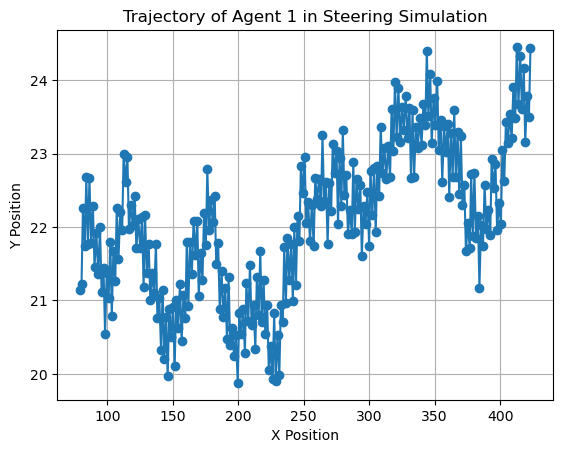

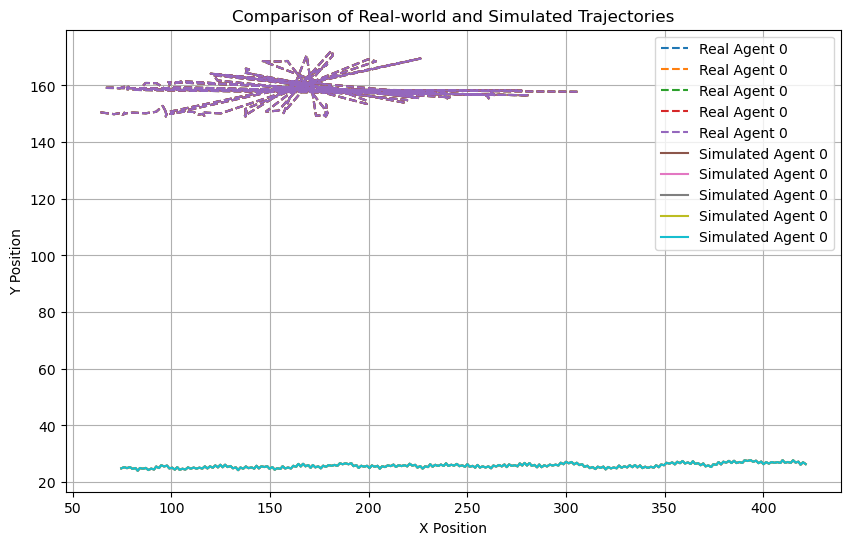

In [2170]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot the trajectory of the second agent (agent_idx = 1)
agent_idx = 1
trajectory = np.array([state[agent_idx] for state in steering_states])
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.title('Trajectory of Agent 1 in Steering Simulation')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.show()

# Plot comparison of real-world data and simulated data
# Select a few agents for visualization
num_agents_to_plot = 5
selected_agents = np.random.choice(num_agents, num_agents_to_plot, replace=True)

# Plot trajectories
plt.figure(figsize=(10, 6))

# Plot real-world data
for agent_idx in selected_agents:
    real_trajectory = real_positions_df[real_positions_df['id'] == agent_idx][['center_x', 'center_y']].values
    plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], label=f'Real Agent {agent_idx}', linestyle='--')

# Plot simulated data
for agent_idx in selected_agents:
    simulated_trajectory = np.array([state[agent_idx] for state in steering_states])
    plt.plot(simulated_trajectory[:, 0], simulated_trajectory[:, 1], label=f'Simulated Agent {agent_idx}')

plt.title('Comparison of Real-world and Simulated Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


In [2171]:
pd.read_csv('steering_simulated_states.csv').tail()

,sim_center_x,sim_center_y,frame
256,416.297679,26.902552,256
257,417.766256,27.207975,257
258,418.819042,26.139499,258
259,420.051276,26.994835,259
260,421.413164,26.366137,260


### Data visualization of steering model simulation

In [2172]:
import cv2

# Define the function to create video from trajectories of both agents
def create_trajectory_video(agent0_trajectory, agent1_trajectory, output_path, target_shape=(480, 640), fps=20):
    frame_width = target_shape[1]
    frame_height = target_shape[0]
    num_frames = min(len(agent0_trajectory), len(agent1_trajectory))

    # Reverse the x-coordinates of agent0 to move from right to left
    max_x = agent0_trajectory[:, 0].max()
    agent0_trajectory[:, 0] = max_x - agent0_trajectory[:, 0]

    # Create a VideoWriter object
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    for i in range(num_frames-1):
        # Create a blank frame
        blank_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

        # Plot the points up to the current frame for agent 0
        for j in range(i+1):
            x0 = int(agent0_trajectory[j][0]) + 100
            y0 = int(agent0_trajectory[j][1]) + 180
            cv2.circle(blank_frame, (x0, y0), 5, (0, 0, 255), -1)  # Draw the trajectory points of agent 0 in red

        # Plot the points up to the current frame for agent 1
        for j in range(i+1):
            x1 = int(agent1_trajectory[j][0]) + 100
            y1 = int(agent1_trajectory[j][1]) + 210
            cv2.circle(blank_frame, (x1, y1), 5, (0, 255, 0), -1)  # Draw the trajectory points of agent 1 in green

        # Add titles and labels
        cv2.putText(blank_frame, f'Steering Model, Entropy: {entropy_metric_steering}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(blank_frame, f'Frame: {i+1}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Write the frame to the video
        out.write(blank_frame)

        print(f"Processed frame {i+1}")

    # Release the VideoWriter object
    out.release()
    print(f"Video saved to {output_path}")

# Example trajectory data (replace with actual trajectory data)
agent0_trajectory = np.array([state[0] for state in steering_states])  # the trajectory is for agent index 0
agent1_trajectory = np.array([state[1] for state in steering_states])  # the trajectory is for agent index 1

# Create video from the trajectories
create_trajectory_video(agent0_trajectory, agent1_trajectory, 'Steering_model_simulation.mp4')


Processed frame 1
Processed frame 2
Processed frame 3
Processed frame 4
Processed frame 5
Processed frame 6
Processed frame 7
Processed frame 8
Processed frame 9
Processed frame 10
Processed frame 11
Processed frame 12
Processed frame 13
Processed frame 14
Processed frame 15
Processed frame 16
Processed frame 17
Processed frame 18
Processed frame 19
Processed frame 20
Processed frame 21
Processed frame 22
Processed frame 23
Processed frame 24
Processed frame 25
Processed frame 26
Processed frame 27
Processed frame 28
Processed frame 29
Processed frame 30
Processed frame 31
Processed frame 32
Processed frame 33
Processed frame 34
Processed frame 35
Processed frame 36
Processed frame 37
Processed frame 38
Processed frame 39
Processed frame 40
Processed frame 41
Processed frame 42
Processed frame 43
Processed frame 44
Processed frame 45
Processed frame 46
Processed frame 47
Processed frame 48
Processed frame 49
Processed frame 50
Processed frame 51
Processed frame 52
Processed frame 53
Pr

### Social Force model

In [2226]:
class SocialForceModel:
    def __init__(self, num_agents, goal, relaxation_time=0.5, interaction_range=20.0, repulsion_strength=2.1, interaction_strength=0.3):
        self.num_agents = num_agents
        self.goal = goal
        self.relaxation_time = relaxation_time
        self.interaction_range = interaction_range
        self.repulsion_strength = repulsion_strength
        self.interaction_strength = interaction_strength
        self.positions = np.random.rand(num_agents, 2) * 100  # Initial positions
        self.velocities = np.zeros((num_agents, 2))

    def update_forces(self, positions, velocities):
        forces = np.zeros_like(positions)
        for i in range(self.num_agents):
            # Desired force towards goal
            desired_velocity = self.goal - positions[i]
            desired_velocity /= np.linalg.norm(desired_velocity)
            forces[i] += (desired_velocity - velocities[i]) / self.relaxation_time

            # Interaction forces with other agents
            for j in range(self.num_agents):
                if i != j:
                    distance = positions[i] - positions[j]
                    distance_norm = np.linalg.norm(distance)
                    if distance_norm < self.interaction_range:
                        repulsion = self.repulsion_strength * np.exp((self.positions[i] + self.positions[j] - distance_norm) / self.interaction_strength) * (distance / distance_norm)
                        forces[i] += repulsion

        return forces

    def simulate(self, timesteps, dt=0.1):
        state_history = [self.positions.copy()]
        for t in range(timesteps):
            forces = self.update_forces(self.positions, self.velocities)
            self.velocities += forces * dt
            self.positions += self.velocities * dt
            state_history.append(self.positions.copy())
        return state_history

def compute_entropy_mle(errors):
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    entropy = np.log(2 * np.pi * np.e * error_std**2) / 2
    return entropy, error_mean, error_std

# Load the positions file
positions_df = pd.read_csv('positions.csv')
measurements = positions_df[['center_x', 'center_y']].values

# Initialize parameters
num_agents = 2  
goal = np.array([700, 700])  # Example goal
timesteps = frame_num+1#len(measurements)

# Create a social force model instance
social_force_model = SocialForceModel(num_agents=num_agents, goal=goal)

# Simulate the social force model
social_force_states = social_force_model.simulate(timesteps)

# Align real-world data and simulated data by frame numbers
real_positions = measurements

# Flatten the list of states and select the corresponding positions
aligned_simulated_positions = np.vstack(social_force_states)

# Ensure we compare the same number of positions
aligned_simulated_positions = aligned_simulated_positions[:len(real_positions)]

# Calculate the prediction error for each frame
prediction_errors = np.sqrt(
    (real_positions[:, 0] - aligned_simulated_positions[:, 0])**2 +
    (real_positions[:, 1] - aligned_simulated_positions[:, 1])**2
)

# Computing the entropy of the prediction error distribution using MLE
entropy_metric_social_force, error_mean, error_std = compute_entropy_mle(prediction_errors)

print(f"Social Force Model Entropy: {entropy_metric_social_force}")
print(f"Error Mean: {error_mean}, Error Std: {error_std}")

# Saved the simulated states to a CSV file
social_force_df = pd.DataFrame(aligned_simulated_positions, columns=['sim_center_x', 'sim_center_y'])
social_force_df['frame'] = positions_df['frame'][:len(aligned_simulated_positions)]
social_force_df.to_csv('social_force_simulated_states.csv', index=False)

print("Social force model simulation complete. Simulated states saved to 'social_force_simulated_states.csv'.")


Social Force Model Entropy: 5.0617475377264585
Error Mean: 174.15782262295605, Error Std: 38.19898728975766
Social force model simulation complete. Simulated states saved to 'social_force_simulated_states.csv'.


### Agent 0 trajectory

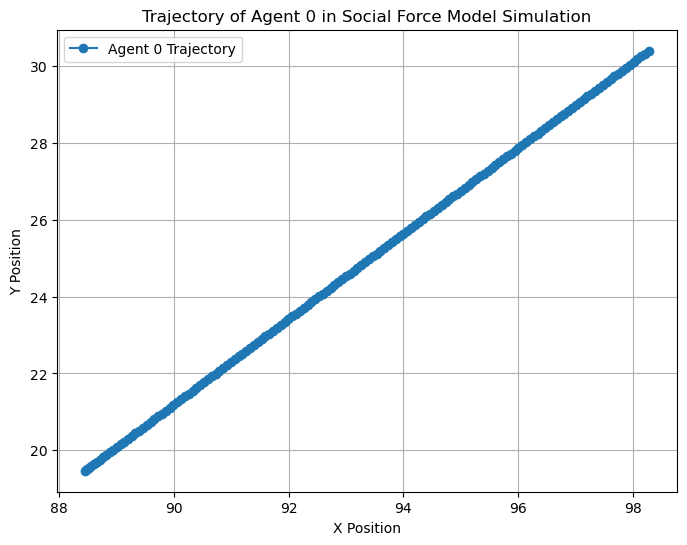

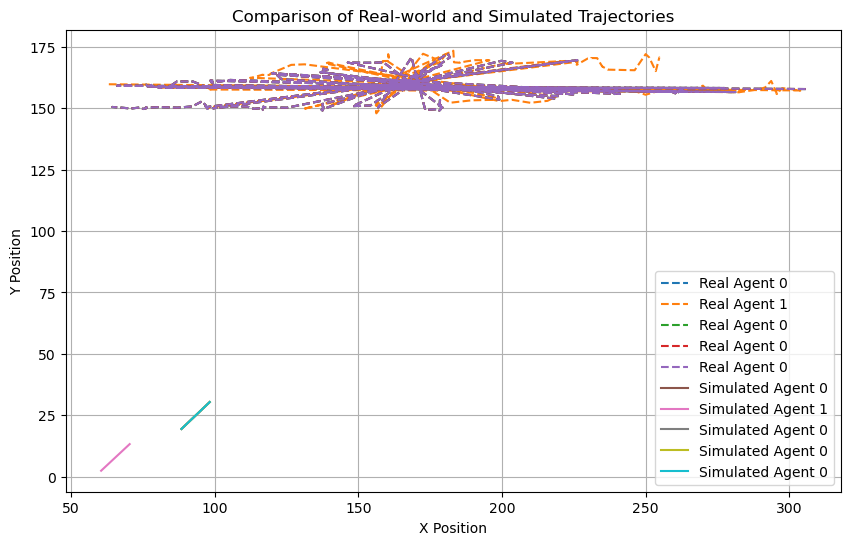

In [2227]:
agent_idx = 0
# Load the real-world positions and simulated states
real_positions_df = pd.read_csv('positions.csv')
simulated_states_df = pd.read_csv('social_force_simulated_states.csv')

# Add 'id' column to simulated_states_df assuming it has only two agents
simulated_states_df['id'] = np.tile([0, 1], len(simulated_states_df) // 2)

# Filter out the trajectory for agent 0
agent_0_trajectory = simulated_states_df[simulated_states_df['id'] == 0][['sim_center_x', 'sim_center_y']].values

# Plot the trajectory of agent 0
plt.figure(figsize=(8, 6))
plt.plot(agent_0_trajectory[:, 0], agent_0_trajectory[:, 1], marker='o', label='Agent 0 Trajectory')
plt.title('Trajectory of Agent 0 in Social Force Model Simulation')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

# Plotting comparison of real-world data and simulated data
num_agents = 2#len(real_positions_df['id'].unique())
num_agents_to_plot = 5
selected_agents = np.random.choice(num_agents, num_agents_to_plot, replace=True)

# Plot trajectories
plt.figure(figsize=(10, 6))

# Plot real-world data
for agent_idx in selected_agents:
    real_trajectory = real_positions_df[real_positions_df['id'] == agent_idx][['center_x', 'center_y']].values
    plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], label=f'Real Agent {agent_idx}', linestyle='--')

# Plot simulated data
for agent_idx in selected_agents:
    simulated_trajectory = simulated_states_df[simulated_states_df['id'] == agent_idx][['sim_center_x', 'sim_center_y']].values
    plt.plot(simulated_trajectory[:, 0], simulated_trajectory[:, 1], label=f'Simulated Agent {agent_idx}')

plt.title('Comparison of Real-world and Simulated Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


### Agent 1 trajectory

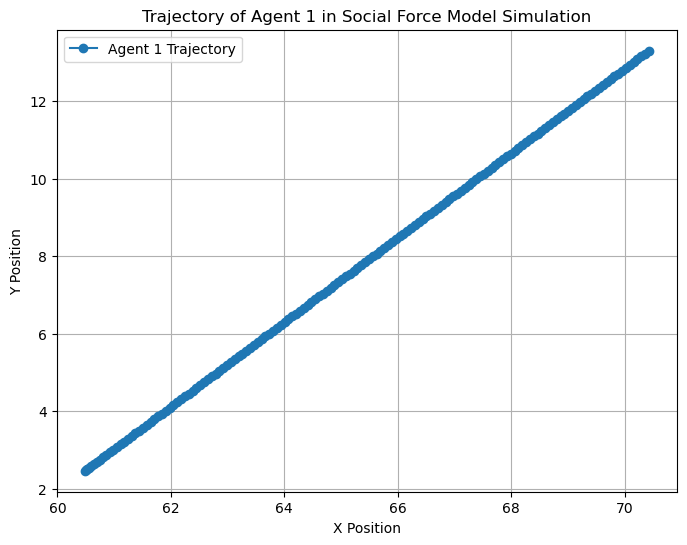

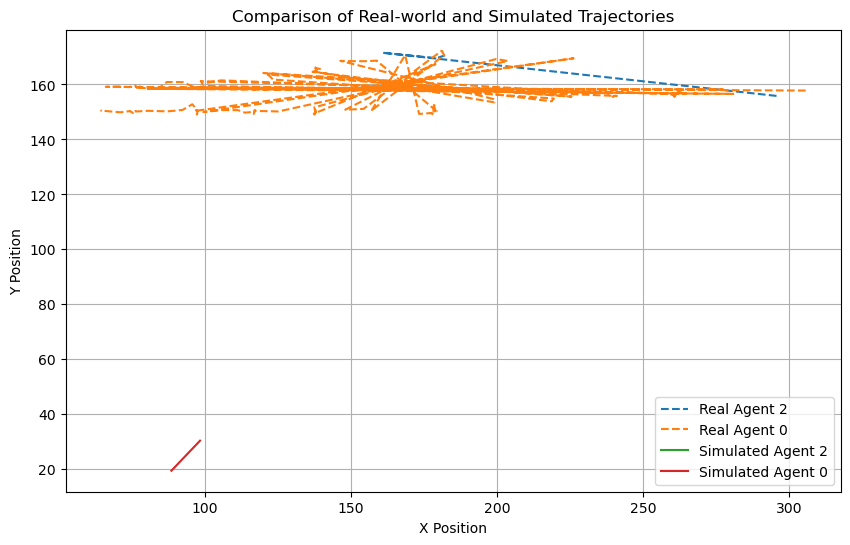

In [2228]:
agent_idx = 1
# Load the real-world positions and simulated states
real_positions_df = pd.read_csv('positions.csv')
simulated_states_df = pd.read_csv('social_force_simulated_states.csv')

# Add 'id' column to simulated_states_df assuming it has only two agents
simulated_states_df['id'] = np.tile([0, 1], len(simulated_states_df) // 2)

# Plot the trajectory of agent 1
agent_1_trajectory = simulated_states_df[simulated_states_df['id'] == agent_idx][['sim_center_x', 'sim_center_y']].values
plt.figure(figsize=(8, 6))
plt.plot(agent_1_trajectory[:, 0], agent_1_trajectory[:, 1], marker='o', label='Agent 1 Trajectory')
plt.title('Trajectory of Agent 1 in Social Force Model Simulation')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

# Plotting comparison of real-world data and simulated data
num_agents = 2#real_positions_df['id'].nunique()
num_agents_to_plot = min(5, num_agents)  # Plot up to 5 agents or the number of agents available
selected_agents = np.random.choice(real_positions_df['id'].unique(), num_agents_to_plot, replace=False)

# Plot trajectories
plt.figure(figsize=(10, 6))

# Plot real-world data
for agent_idx in selected_agents:
    real_trajectory = real_positions_df[real_positions_df['id'] == agent_idx][['center_x', 'center_y']].values
    plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], label=f'Real Agent {agent_idx}', linestyle='--')

# Plot simulated data
for agent_idx in selected_agents:
    simulated_trajectory = simulated_states_df[simulated_states_df['id'] == agent_idx][['sim_center_x', 'sim_center_y']].values
    plt.plot(simulated_trajectory[:, 0], simulated_trajectory[:, 1], label=f'Simulated Agent {agent_idx}')

plt.title('Comparison of Real-world and Simulated Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


In [2229]:
new_df = pd.read_csv('social_force_simulated_states.csv')
fin_df = new_df.sort_values(by='frame')
fin_df.to_csv('new.csv', index=False)
pd.read_csv('new.csv').tail()

,sim_center_x,sim_center_y,frame
299,93.867510,25.493378,255
300,65.964393,8.439149,256
301,93.934351,25.567758,257
302,66.031972,8.512858,258
303,94.001191,25.642138,259


### Data visualization of social force model

In [2273]:
import cv2
import numpy as np
import pandas as pd
from math import atan2

# Function to rotate points around the origin
def rotate_points(points, angle):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return points.dot(rotation_matrix.T)

# Function to calculate the rotation angle
def calculate_rotation_angle(points):
    dx = points[-1][0] - points[0][0]
    dy = points[-1][1] - points[0][1]
    return -atan2(dy, dx)

# Define the function to create video from trajectories of both agents
def create_combined_trajectory_video(agent0_trajectory, agent1_trajectory, output_path, target_shape=(480, 640), fps=10, scaling_factor=15):
    frame_width = target_shape[1]
    frame_height = target_shape[0]
    num_frames = max(len(agent0_trajectory), len(agent1_trajectory))

    # Calculate rotation angles
    angle_agent0 = calculate_rotation_angle(agent0_trajectory)
    angle_agent1 = calculate_rotation_angle(agent1_trajectory)

    # Rotate and scale trajectories to make them horizontal
    agent0_trajectory_rotated = rotate_points(agent0_trajectory, angle_agent0) * scaling_factor
    agent1_trajectory_rotated = rotate_points(agent1_trajectory, angle_agent1) * scaling_factor
    
    # Calculate the bounds of the trajectories
    all_points = np.vstack([agent0_trajectory_rotated, agent1_trajectory_rotated])
    min_x, min_y = np.min(all_points, axis=0)
    max_x, max_y = np.max(all_points, axis=0)
    
    # Calculate the center offset
    offset_x = (frame_width - (max_x - min_x)) // 2 - min_x
    offset_y = (frame_height - (max_y - min_y)) // 2 - min_y

    # Create a VideoWriter object
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    for i in range(num_frames):
        # Create a blank frame
        blank_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

        # Plot the points for agent 0 up to the current frame
        #if i < len(agent0_trajectory_rotated):
        for j in range(i+1):
                x0 = int(agent0_trajectory_rotated[-j][0] + offset_x - 250) 
                y0 = int(agent0_trajectory_rotated[-j][1] + offset_y + 50) 
                cv2.circle(blank_frame, (x0, y0), 5, (0, 0, 255), -1)  # Draw agent 0's trajectory points in red

        # Plot the points for agent 1 up to the current frame
        #if i < len(agent1_trajectory_rotated):
        for j in range(i+1):
                x1 = int(agent1_trajectory_rotated[j][0] + offset_x + 180) 
                y1 = int(agent1_trajectory_rotated[j][1] + offset_y - 130) 
                cv2.circle(blank_frame, (x1, y1), 5, (0, 255, 0), -1)  # Draw agent 1's trajectory points in green

        # Add titles and labels
        cv2.putText(blank_frame, f'Social Force Model, Entropy: {entropy_metric_social_force}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(blank_frame, f'Frame: {i+1}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Write the frame to the video
        out.write(blank_frame)

        print(f"Processed frame {i+1}/{num_frames}")

    # Release the VideoWriter object
    out.release()
    print(f"Video saved to {output_path}")

# Load the simulated states data for agent 0 and agent 1
social_force_states_df = pd.read_csv('social_force_simulated_states.csv')

# Add the 'id' column if it doesn't exist
if 'id' not in social_force_states_df.columns:
    social_force_states_df['id'] = np.tile([0, 1], len(social_force_states_df) // 2)

agent0_trajectory = social_force_states_df[social_force_states_df['id'] == 0][['sim_center_x', 'sim_center_y']].values
agent1_trajectory = social_force_states_df[social_force_states_df['id'] == 1][['sim_center_x', 'sim_center_y']].values

# Ensure all frames are processed by checking the data length
print(f"Total frames for agent 0: {len(agent0_trajectory)}")
print(f"Total frames for agent 1: {len(agent1_trajectory)}")

# Create the combined video from the trajectories of agent 0 and agent 1
create_combined_trajectory_video(agent0_trajectory, agent1_trajectory, 'social_force_model_simulation.mp4', scaling_factor=20)


Total frames for agent 0: 152
Total frames for agent 1: 152
Processed frame 1/152
Processed frame 2/152
Processed frame 3/152
Processed frame 4/152
Processed frame 5/152
Processed frame 6/152
Processed frame 7/152
Processed frame 8/152
Processed frame 9/152
Processed frame 10/152
Processed frame 11/152
Processed frame 12/152
Processed frame 13/152
Processed frame 14/152
Processed frame 15/152
Processed frame 16/152
Processed frame 17/152
Processed frame 18/152
Processed frame 19/152
Processed frame 20/152
Processed frame 21/152
Processed frame 22/152
Processed frame 23/152
Processed frame 24/152
Processed frame 25/152
Processed frame 26/152
Processed frame 27/152
Processed frame 28/152
Processed frame 29/152
Processed frame 30/152
Processed frame 31/152
Processed frame 32/152
Processed frame 33/152
Processed frame 34/152
Processed frame 35/152
Processed frame 36/152
Processed frame 37/152
Processed frame 38/152
Processed frame 39/152
Processed frame 40/152
Processed frame 41/152
Proces

### Predictive Planning model

In [2270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

def distance(pose1, pose2):
    """ Compute Euclidean distance for 2D """
    return np.sqrt((pose1[0]-pose2[0])**2 + (pose1[1]-pose2[1])**2) + 0.001

def RVO_update(X, V_des, V_current, ws_model):
    """ Compute best velocity given the desired velocity, current velocity and workspace model"""
    ROB_RAD = ws_model['robot_radius'] + 0.1
    V_opt = list(V_current)
    for i in range(len(X)):
        vA = [V_current[i][0], V_current[i][1]]
        pA = [X[i][0], X[i][1]]
        RVO_BA_all = []
        for j in range(len(X)):
            if i != j:
                vB = [V_current[j][0], V_current[j][1]]
                pB = [X[j][0], X[j][1]]
                transl_vB_vA = [pA[0] + 0.5 * (vB[0] + vA[0]), pA[1] + 0.5 * (vB[1] + vA[1])]
                dist_BA = distance(pA, pB)
                theta_BA = np.arctan2(pB[1] - pA[1], pB[0] - pA[0])
                if 2 * ROB_RAD > dist_BA:
                    dist_BA = 2 * ROB_RAD
                theta_BAort = np.arcsin(2 * ROB_RAD / dist_BA)
                theta_ort_left = theta_BA + theta_BAort
                bound_left = [np.cos(theta_ort_left), np.sin(theta_ort_left)]
                theta_ort_right = theta_BA - theta_BAort
                bound_right = [np.cos(theta_ort_right), np.sin(theta_ort_right)]
                RVO_BA = [transl_vB_vA, bound_left, bound_right, dist_BA, 2 * ROB_RAD]
                RVO_BA_all.append(RVO_BA)
        
        for hole in ws_model['circular_obstacles']:
            vB = [0, 0]
            pB = hole[0:2]
            transl_vB_vA = [pA[0] + vB[0], pA[1] + vB[1]]
            dist_BA = distance(pA, pB)
            theta_BA = np.arctan2(pB[1] - pA[1], pB[0] - pA[0])
            rad = hole[2] * 1.5
            if (rad + ROB_RAD) > dist_BA:
                dist_BA = rad + ROB_RAD
            theta_BAort = np.arcsin((rad + ROB_RAD) / dist_BA)
            theta_ort_left = theta_BA + theta_BAort
            bound_left = [np.cos(theta_ort_left), np.sin(theta_ort_left)]
            theta_ort_right = theta_BA - theta_BAort
            bound_right = [np.cos(theta_ort_right), np.sin(theta_ort_right)]
            RVO_BA = [transl_vB_vA, bound_left, bound_right, dist_BA, rad + ROB_RAD]
            RVO_BA_all.append(RVO_BA)
        
        vA_post = intersect(pA, V_des[i], RVO_BA_all)
        V_opt[i] = vA_post[:]
    return V_opt

def intersect(pA, vA, RVO_BA_all):
    norm_v = distance(vA, [0, 0])
    suitable_V = []
    unsuitable_V = []
    for theta in np.arange(0, 2 * np.pi, 0.1):
        for rad in np.arange(0.02, norm_v + 0.02, norm_v / 5.0):
            new_v = [rad * np.cos(theta), rad * np.sin(theta)]
            suit = True
            for RVO_BA in RVO_BA_all:
                p_0 = RVO_BA[0]
                left = RVO_BA[1]
                right = RVO_BA[2]
                dif = [new_v[0] + pA[0] - p_0[0], new_v[1] + pA[1] - p_0[1]]
                theta_dif = np.arctan2(dif[1], dif[0])
                theta_right = np.arctan2(right[1], right[0])
                theta_left = np.arctan2(left[1], left[0])
                if in_between(theta_right, theta_dif, theta_left):
                    suit = False
                    break
            if suit:
                suitable_V.append(new_v)
            else:
                unsuitable_V.append(new_v)
                
    new_v = vA[:]
    suit = True
    for RVO_BA in RVO_BA_all:
        p_0 = RVO_BA[0]
        left = RVO_BA[1]
        right = RVO_BA[2]
        dif = [new_v[0] + pA[0] - p_0[0], new_v[1] + pA[1] - p_0[1]]
        theta_dif = np.arctan2(dif[1], dif[0])
        theta_right = np.arctan2(right[1], right[0])
        theta_left = np.arctan2(left[1], left[0])
        if in_between(theta_right, theta_dif, theta_left):
            suit = False
            break
    if suit:
        suitable_V.append(new_v)
    else:
        unsuitable_V.append(new_v)
    
    if suitable_V:
        vA_post = min(suitable_V, key=lambda v: distance(v, vA))
        new_v = vA_post[:]
        for RVO_BA in RVO_BA_all:
            p_0 = RVO_BA[0]
            left = RVO_BA[1]
            right = RVO_BA[2]
            dif = [new_v[0] + pA[0] - p_0[0], new_v[1] + pA[1] - p_0[1]]
            theta_dif = np.arctan2(dif[1], dif[0])
            theta_right = np.arctan2(right[1], right[0])
            theta_left = np.arctan2(left[1], left[0])
    else:
        tc_V = dict()
        for unsuit_v in unsuitable_V:
            tc_V[tuple(unsuit_v)] = 0
            tc = []
            for RVO_BA in RVO_BA_all:
                p_0 = RVO_BA[0]
                left = RVO_BA[1]
                right = RVO_BA[2]
                dist = RVO_BA[3]
                rad = RVO_BA[4]
                dif = [unsuit_v[0] + pA[0] - p_0[0], unsuit_v[1] + pA[1] - p_0[1]]
                theta_dif = np.arctan2(dif[1], dif[0])
                theta_right = np.arctan2(right[1], right[0])
                theta_left = np.arctan2(left[1], left[0])
                if in_between(theta_right, theta_dif, theta_left):
                    small_theta = abs(theta_dif - 0.5 * (theta_left + theta_right))
                    if abs(dist * np.sin(small_theta)) >= rad:
                        rad = abs(dist * np.sin(small_theta))
                    big_theta = np.arcsin(abs(dist * np.sin(small_theta)) / rad)
                    dist_tg = abs(dist * np.cos(small_theta)) - abs(rad * np.cos(big_theta))
                    if dist_tg < 0:
                        dist_tg = 0
                    tc_v = dist_tg / distance(dif, [0, 0])
                    tc.append(tc_v)
            tc_V[tuple(unsuit_v)] = min(tc) + 0.001
        WT = 0.2
        vA_post = min(unsuitable_V, key=lambda v: ((WT / tc_V[tuple(v)]) + distance(v, vA)))
    return vA_post

def in_between(theta_right, theta_dif, theta_left):
    if abs(theta_right - theta_left) <= np.pi:
        if theta_right <= theta_dif <= theta_left:
            return True
        else:
            return False
    else:
        if (theta_left < 0) and (theta_right > 0):
            theta_left += 2 * np.pi
            if theta_dif < 0:
                theta_dif += 2 * np.pi
            if theta_right <= theta_dif <= theta_left:
                return True
            else:
                return False
        if (theta_left > 0) and (theta_right < 0):
            theta_right += 2 * np.pi
            if theta_dif < 0:
                theta_dif += 2 * np.pi
            if theta_left <= theta_dif <= theta_right:
                return True
            else:
                return False
    return False

def compute_V_des(X, goal, V_max):
    V_des = []
    for i in range(len(X)):
        dif_x = [goal[i][k] - X[i][k] for k in range(2)]
        norm = distance(dif_x, [0, 0])
        norm_dif_x = [dif_x[k] * V_max / norm for k in range(2)]
        V_des.append(norm_dif_x[:])
        if reach(X[i], goal[i], 0.1):
            V_des[i][0] = 0
            V_des[i][1] = 0
    return V_des

def reach(p1, p2, bound=0.5):
    if distance(p1, p2) < bound:
        return True
    else:
        return False

num_agents = 2
timesteps = 260
goal = np.array([[700, 7], [700, 7]])  # Example goal positions for agents
V_max = 1.0  # Maximum speed for agents

# Initialize positions and velocities
X = np.array([[60, 160], [300, 160]])  # Initial positions of agents
V_current = np.zeros_like(X)  # Initial velocities of agents

# Workspace model with no obstacles for simplicity
ws_model = {
    'robot_radius': 1.0,
    'circular_obstacles': []
}

# State history to keep track of positions
state_history = []

# Perform the RVO simulation
for t in range(timesteps):
    V_des = compute_V_des(X, goal, V_max)
    V_current = RVO_update(X, V_des, V_current, ws_model)
    X = X + V_current  # Update positions based on velocities
    state_history.append(X.copy())

# Convert state history to a DataFrame for further processing
flattened_states = np.array(state_history).reshape(-1, 2)

agent_ids = np.tile(np.arange(num_agents), timesteps)
frame_ids = np.repeat(np.arange(timesteps), num_agents)

predictive_planning_states_df = pd.DataFrame({
    'frame': frame_ids,
    'id': agent_ids,
    'sim_center_x': flattened_states[:, 0],
    'sim_center_y': flattened_states[:, 1]
})

# Save the simulated states to a CSV file
predictive_planning_states_df.to_csv('predictive_planning_simulated_states.csv', index=False)

print("Predictive planning simulation complete. Simulated states saved to 'predictive_planning_simulated_states.csv'.")

# Entropy calculation functions
def compute_entropy_mle(errors):
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    entropy = np.log(2 * np.pi * np.e * error_std ** 2) / 2
    return entropy, error_mean, error_std

# Calculate the error between real and simulated positions
aligned_real_positions = real_positions_df[['center_x', 'center_y']].values
aligned_simulated_positions = predictive_planning_states_df[['sim_center_x', 'sim_center_y']].values
aligned_simulated_positions = aligned_simulated_positions[:len(aligned_real_positions)]

prediction_errors = np.sqrt(
    (aligned_real_positions[:aligned_simulated_positions.shape[0], 0] - aligned_simulated_positions[:, 0]) ** 2 +
    (aligned_real_positions[:aligned_simulated_positions.shape[0], 1] - aligned_simulated_positions[:, 1]) ** 2
)

# Compute the entropy, error mean, and error std
entropy_metric_predictive, error_mean, error_std = compute_entropy_mle(prediction_errors)

print(f"Predictive Planning Model Entropy: {entropy_metric_predictive}")
print(f"Error Mean: {error_mean}, Error Std: {error_std}")


Predictive planning simulation complete. Simulated states saved to 'predictive_planning_simulated_states.csv'.
Predictive Planning Model Entropy: 5.964023930360252
Error Mean: 137.77331320780596, Error Std: 94.16846858540904


In [2271]:
pd.read_csv('predictive_planning_simulated_states.csv').tail()

,frame,id,sim_center_x,sim_center_y
515,257,1,540.972690,67.827946
516,258,0,311.901317,99.779841
517,258,1,541.906691,67.470691
518,259,0,312.873909,99.547331
519,259,1,542.840691,67.113436


### Agent 0 trajectory

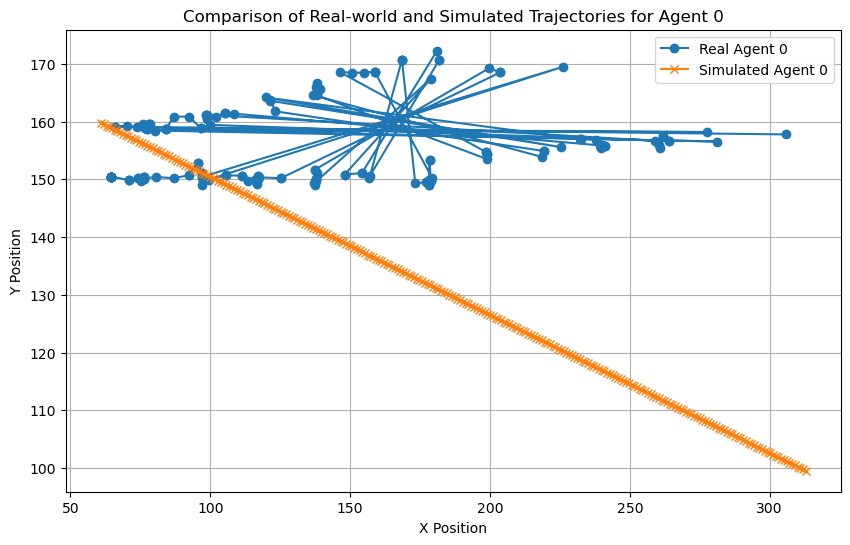

In [2257]:
# Load the real-world positions file
real_positions_df = pd.read_csv('positions.csv')

# Load the simulated states file for the social force model
predictive_planning_states_df = pd.read_csv('predictive_planning_simulated_states.csv')

# Plot the trajectory of agent 0
agent_idx = 0
agent0_trajectory = predictive_planning_states_df[predictive_planning_states_df['id'] == agent_idx][['sim_center_x', 'sim_center_y']].values

# Plot real-world data for agent 0
real_agent0_trajectory = real_positions_df[real_positions_df['id'] == agent_idx][['center_x', 'center_y']].values

plt.figure(figsize=(10, 6))
plt.plot(real_agent0_trajectory[:, 0], real_agent0_trajectory[:, 1], marker='o', label='Real Agent 0')
plt.plot(agent0_trajectory[:, 0], agent0_trajectory[:, 1], marker='x', label='Simulated Agent 0')
plt.title('Comparison of Real-world and Simulated Trajectories for Agent 0')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

### Agent 1 trajectory

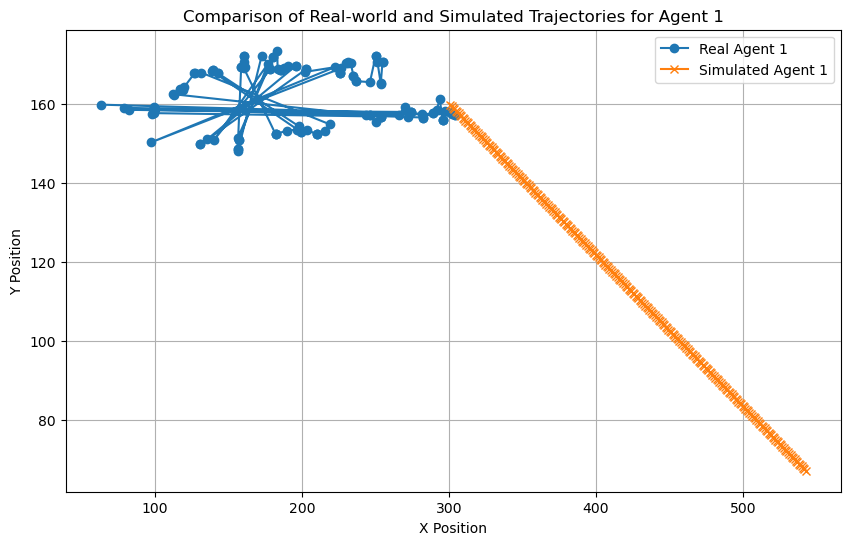

In [2259]:

# Verify the data for agent 1
agent_idx = 1
real_agent1_data = real_positions_df[real_positions_df['id'] == agent_idx]
sim_agent1_data = predictive_planning_states_df[predictive_planning_states_df['id'] == agent_idx]

# Plot the trajectory of agent 1
agent1_trajectory = sim_agent1_data[['sim_center_x', 'sim_center_y']].values

# Plot real-world data for agent 1
real_agent1_trajectory = real_agent1_data[['center_x', 'center_y']].values

plt.figure(figsize=(10, 6))
plt.plot(real_agent1_trajectory[:, 0], real_agent1_trajectory[:, 1], marker='o', label='Real Agent 1')
plt.plot(agent1_trajectory[:, 0], agent1_trajectory[:, 1], marker='x', label='Simulated Agent 1')
plt.title('Comparison of Real-world and Simulated Trajectories for Agent 1')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

### Data visualization of predictive planning model

In [2279]:
from math import radians, cos, sin

# Function to rotate points around the origin
def rotate_points(points, angle_degrees):
    angle = radians(angle_degrees)
    rotation_matrix = np.array([
        [cos(angle), -sin(angle)],
        [sin(angle), cos(angle)]
    ])
    return points.dot(rotation_matrix.T)

# Function to create a video from the trajectories of both agents
def create_combined_trajectory_video(agent0_trajectory, agent1_trajectory, output_path, angle=0, target_shape=(720, 1000), fps=20):
    frame_width = target_shape[1]
    frame_height = target_shape[0]
    num_frames = min(len(agent0_trajectory), len(agent1_trajectory))

    # Rotate the trajectories
    agent0_trajectory_rotated = rotate_points(agent0_trajectory, angle)
    agent1_trajectory_rotated = rotate_points(agent1_trajectory, angle)

    # Calculate translation offsets to bring agents to center
    offset_x = frame_width // 2 - int((agent0_trajectory_rotated[0, 0] + agent1_trajectory_rotated[0, 0]) / 2)
    offset_y = frame_height // 2 - int((agent0_trajectory_rotated[0, 1] + agent1_trajectory_rotated[0, 1]) / 2)

    # Create a VideoWriter object
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    for i in range(num_frames):
        # Create a blank frame
        blank_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

        # Plot the points for agent 0 up to the current frame
        for j in range(i+1):
            x0 = int(agent0_trajectory_rotated[-j][0]) + offset_x
            y0 = int(agent0_trajectory_rotated[-j][1]) + offset_y
            cv2.circle(blank_frame, (x0, y0), 5, (0, 0, 255), -1)  # Draw agent 0's trajectory points in red

        # Plot the points for agent 1 up to the current frame
        for j in range(i+1):
            x1 = int(agent1_trajectory_rotated[j][0]) + offset_x - 170
            y1 = int(agent1_trajectory_rotated[j][1]) + offset_y - 20
            cv2.circle(blank_frame, (x1, y1), 5, (0, 255, 0), -1)  # Draw agent 1's trajectory points in green

        # Add titles and labels
        cv2.putText(blank_frame, f'Predictive Planning Model, Entropy: {entropy_metric_predictive}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(blank_frame, f'Frame: {i+1}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Write the frame to the video
        out.write(blank_frame)

        print(f"Processed frame {i+1}")

    # Release the VideoWriter object
    out.release()
    print(f"Video saved to {output_path}")

# Load the simulated states data for agent 0 and agent 1
predictive_planning_states_df = pd.read_csv('predictive_planning_simulated_states.csv')

agent0_trajectory = predictive_planning_states_df[predictive_planning_states_df['id'] == 0][['sim_center_x', 'sim_center_y']].values
agent1_trajectory = predictive_planning_states_df[predictive_planning_states_df['id'] == 1][['sim_center_x', 'sim_center_y']].values

# Create the combined video from the trajectories of agent 0 and agent 1
create_combined_trajectory_video(agent0_trajectory, agent1_trajectory, 'predictive_planning_model_simulation.mp4', angle=15)


Processed frame 1
Processed frame 2
Processed frame 3
Processed frame 4
Processed frame 5
Processed frame 6
Processed frame 7
Processed frame 8
Processed frame 9
Processed frame 10
Processed frame 11
Processed frame 12
Processed frame 13
Processed frame 14
Processed frame 15
Processed frame 16
Processed frame 17
Processed frame 18
Processed frame 19
Processed frame 20
Processed frame 21
Processed frame 22
Processed frame 23
Processed frame 24
Processed frame 25
Processed frame 26
Processed frame 27
Processed frame 28
Processed frame 29
Processed frame 30
Processed frame 31
Processed frame 32
Processed frame 33
Processed frame 34
Processed frame 35
Processed frame 36
Processed frame 37
Processed frame 38
Processed frame 39
Processed frame 40
Processed frame 41
Processed frame 42
Processed frame 43
Processed frame 44
Processed frame 45
Processed frame 46
Processed frame 47
Processed frame 48
Processed frame 49
Processed frame 50
Processed frame 51
Processed frame 52
Processed frame 53
Pr